In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

# Standard library imports
import os
from functools import partial
from math import pi
import json
from collections import defaultdict
import random

import numpy as np
import pandas as pd
import networkx as nx

# Imports for working with shapefiles
import pyproj
from shapely.geometry import (
    shape,
    MultiPolygon,
    mapping
)
from shapely.ops import (
    transform,
    cascaded_union
)
import fiona
from fiona.crs import from_epsg

# local imports
from src.modelling.input import shapes_to_graph
from src.modelling.clustering import SSGraphKMeans

In [4]:
%matplotlib inline

In [5]:
# Create pandas dataframes that have information about each blockgroup
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)
poptot_df['poptot'] = poptot_df['poptot'].apply(int)

In [6]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

# A convenience object for projecting lat/long values
# from EPSG 4326 to 3695 (approximate xy mappings for
# central Wisconsin)
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [7]:
# Create a list of blockgroups, which has a shape, a geoid,
# and an untransformed shape
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': shape(block['geometry']), 
            'geoid': block['properties']['GEOID']
        }
        for block in f
    ]

In [14]:
blocks_graph = shapes_to_graph(blocks)

In [24]:
blocks_shortest_distances = nx.shortest_path_length(blocks_graph)

In [19]:
blocks_graph.number_of_edges()

12233

In [12]:
len(blocks_graph.nodes())

4475

In [20]:
block_geoids = [
    block['geoid']
    for block in blocks
]

In [21]:
block_populations = {
    geoid: int(poptot_df.to_dict()['poptot'][geoid])
    for geoid in block_geoids
}

In [53]:
graph_cluster = SSGraphKMeans()

In [54]:
graph_cluster.fit(blocks_graph, blocks_shortest_distances, block_populations)

Annealing cluster weights to within 50000.0
Annealing cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _an

starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluste

starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluste

ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on clu

ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on cluster 1
ok
starting an iteration inside _anneal on clu

KeyboardInterrupt: 

In [55]:
for i in range(1, 9):
    print(i, nx.is_connected(blocks_graph.subgraph(graph_cluster.clusters[i])))

1 True
2 True
3 False
4 True
5 False
6 True
7 True
8 True


In [56]:
graph_cluster.cluster_weights[1]

348947

In [ ]:
graph_cluster._ideal_cluster_weight

In [ ]:
members_border_totals = [
    (len(graph_cluster.clusters[i]), len(graph_cluster.clusters[i].border))
    for i in range(1, 9)
]

In [ ]:
members_border_totals

In [ ]:
for i in range(1, 9):
    print(nx.is_connected(blocks_graph.subgraph(graph_cluster.clusters[8])))

In [ ]:
max(nx.center(blah), key = block_populations.get)

In [ ]:
blocks_graph['550659704003'].keys()[0]

In [ ]:
nx.draw(blocks_graph.subgraph(graph_cluster.clusters[2]), node_size=150)

In [57]:
len(list(nx.connected_component_subgraphs(blocks_graph)))

1

In [36]:
'550790202001' in list(nx.connected_component_subgraphs(blocks_graph.subgraph(graph_cluster.clusters[8])))[0].nodes()

True

/home/pmende/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/pmende/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/pmende/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/pmende/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

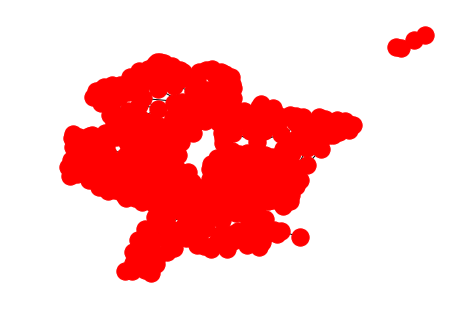

In [29]:
nx.draw(blocks_graph.subgraph(graph_cluster.clusters[8]))

In [ ]:
sum([len(graph_cluster.clusters[i]) for i in range(1, 9)])

In [18]:
blocks_graph['551332027002']

{u'551332022022': {},
 u'551332022025': {},
 u'551332026001': {},
 u'551332026002': {},
 u'551332026003': {},
 u'551332027001': {},
 u'551332030001': {}}